# Kalman filtering to track time delay

grab the data

In [2]:
import pickle

In [3]:
with open('times.pkl','rb') as f:
     data=pickle.load(f)
tlsl=data['lsl-times']
tnaive=data[' naive-times']        

plot the data - so we can see how the timestamps of the lsl data packets keep showing more and more lag relative to the 'naive' timestamps you would've gotten with the assumption of a perfect 125 Hz sampling rate, and 0 loss of transmitted data.
(hint: both assumption are INCORRECT - if both are correct, you'd expect a straight line being always 0 here)

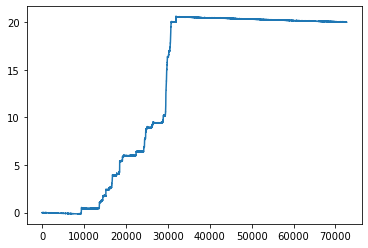

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tlsl - tnaive)
plt.show()

So we need to figure out a way to figure out which time belongs to which sample. If we've got markers from another (clock) device such as as stimulus computer - and we ONLY have the time, then where do we put those markers? Or better: on which SAMPLE do we put that marker in?

Another isue pertains to the detection of missing data as it's being transmitted. Transmitted data is bad, but the measurement is perfectly fine around that. So the best solution is to detect those jumps -- and then to just note the times where such data jumps happen - so we can mark some (short) periods as 'bad data', for our retrospective (speed 0) analyses.

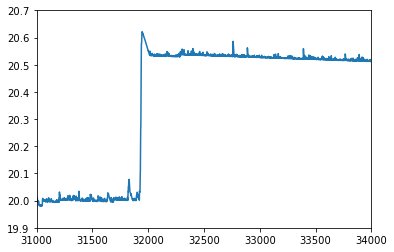

In [6]:
plt.figure()
plt.plot(tlsl - tnaive)
plt.xlim(31000, 34000)
plt.ylim(19.9, 20.7)
plt.show()


## Alpha - Beta Filtering

We cannot just use the times themselves - there is a fair bit of variability on top of that. So we need kind of a smoothed version of it to keep track of things.

There are many tutorial to be found on filtering and smoothing of these kinds of problems, there there is only a single way to really do it properly: Kalman Filtering.
The next best solution would be the alpha-beta filter described here:

[https://www.kalmanfilter.net/alphabeta.html]()

Define the predict and update functions:

In [7]:
def predict(xp, vp):
    xn_prior = xp + vp
    vn_prior = vp
    return (xn_prior, vn_prior)

In [8]:
def update(xn_prior, vn_prior, x_measured):
    alpha = 1/125
    beta = alpha/500
    xn_posterior = xn_prior + alpha * (x_measured - xn_prior)
    vn_posterior = vn_prior + beta * (x_measured - xn_prior)

    return (xn_posterior, vn_posterior)
    

Use the predict and update to keep track of the data:
We keep track of the position (delay value), as well as the 'speed' (d-delay - per - timestep), as we don't know either of these parameters.

We iteratate through our data and obtain the corresponding smoothed values that we can (better) use:

In [9]:
predicted_x = []
updated_x = []
predicted_v = []
updated_v = []

x = 0
v = (tlsl[-1] - tnaive[-1]) / len(tlsl)

for data in tlsl - tnaive:
    new_x_prior, new_v_prior = predict(x, v)
    new_x_posterior, new_y_posterior = update(new_x_prior, new_v_prior, data)
    x, v = (new_x_posterior, new_y_posterior)
    
    predicted_x.append(new_x_prior)
    predicted_v.append(new_v_prior)
    updated_x.append(new_x_posterior)
    updated_v.append(new_y_posterior)
    
    
    

This does a pretty OK job, but fails when things go TOO badly.
Mind you, I played pretty much with choosing the proper alpha (i.e. smoothign of delay) and beta (i.e. smootning of extra-delay-per-timepoint).

We need something that can smooth, but is also adaptable enough to allow for flexibility in uncertain conditions. This is exactly what Kalman is (hopefully) supposed to do for us.

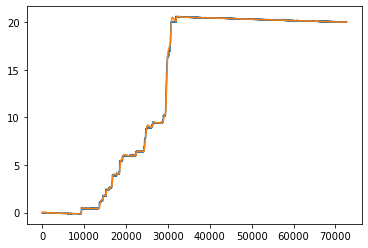

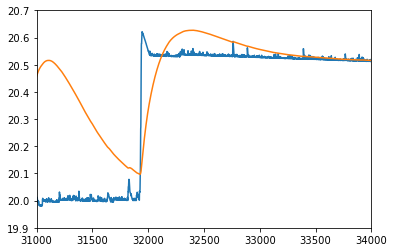

In [10]:
plt.figure()
plt.plot(tlsl - tnaive)
plt.plot(updated_x)


plt.figure()
plt.plot(tlsl - tnaive)
plt.plot(updated_x)
plt.xlim(31000, 34000)
plt.ylim(19.9, 20.7)
plt.show()


## Kalman Filtering

/# we tried copy/paster of the formula for Kalman Gain, but Latex doesn't work yet...
/# \[ \hat{x}_{n,n}=~ \hat{x}_{n,n-1}+ K_{n} \left( z_{n}- \hat{x}_{n,n-1} \right) = \left( 1-K_{n} 
\right) \hat{x}_{n,n-1}+ K_{n}z_{n} \]

so we go here:
https://github.com/akshaychawla/1D-Kalman-Filter

This guy seemed to be on the same path as me. I expect him to be smarter and have put more time in it, so I will use his guide and apply to my timing problem:


Mathematical definitions

In [14]:
import numpy as np

In [15]:
# we say it's position - and velocity.

x = np.matrix([[0.0, 0.0]]).T

In [16]:
print(x)

[[0.]
 [0.]]


In [17]:
# uncertainty?

In [18]:
P = np.diag([100, 1]) # just as example - what is the var in each?

In [19]:
# sampling rate
dt = 1/125

A = np.matrix([[1, dt],
              [0, 1]])

print(A, A.shape)

[[1.    0.008]
 [0.    1.   ]] (2, 2)


In [20]:
# we measure ONLY the position (dt, not the velocity)
H = np.matrix([[1.0, 0]])

print(H, H.shape)

[[1. 0.]] (1, 2)


In [21]:
# noise of measurements
MEAS_NOISE = 100
R = np.matrix([[MEAS_NOISE]])
print(R, R.shape)

[[100]] (1, 1)


In [22]:
sa = 10
G = np.matrix([[dt], [1.0]])
Q = G*G.T*sa**2
print(Q, Q.shape)

[[6.4e-03 8.0e-01]
 [8.0e-01 1.0e+02]] (2, 2)


In [23]:
I = np.eye(2)
print(I, I.shape)

[[1. 0.]
 [0. 1.]] (2, 2)


In [24]:
plt.close('all')

In [25]:
pwd

'/home/johan/nf/nf-rtime/Projects_Templates/9_NF_Basic'

In [32]:
# we define the positions:

measurements = np.vstack(tlsl - tnaive)
m=len(measurements)


In [27]:
for num in plt.get_fignums():
    cf = plt.figure(num)
    fname = 'figure_{}.pkl'.format(num)
    with open(fname,'wb+') as f:
        pickle.dump(cf, f)
    fname = 'figure_{}.jpg'.format(num)
    cf.savefig(fname, dpi=300)
        
        

In [370]:
v1=np.squeeze(measurements)

In [372]:
round(0.5*125)

62

In [29]:
from scipy.ndimage import median_filter

In [30]:
v2=median_filter(v1, round(1*125))

NameError: name 'v1' is not defined

In [385]:
plt.figure()
plt.plot(v1)
plt.plot(v2)
plt.plot(np.diff(v2))
plt.legend(('v1','v2'))

In [414]:
np.std(np.diff(v2))

0.0042255428581408514

In [420]:
plt.figure()
plt.plot(np.abs(np.diff(v2)))

In [421]:
data = np.abs(np.diff(v2))

In [438]:
v=data[np.where((data > 0) and np.where(data < 0.001)]

In [471]:
data[(data > 0) & (data < 0.001)]

array([7.51000203e-07, 7.51000203e-07, 7.51000203e-07, ...,
       3.27999942e-07, 8.12499991e-06, 4.32850002e-05])

In [462]:
data[np.where(data > 0, True, False) & np.where(data < 0.001, True, False)]

array([7.51000203e-07, 7.51000203e-07, 7.51000203e-07, ...,
       3.27999942e-07, 8.12499991e-06, 4.32850002e-05])

In [444]:
v[0]

7.510002033306318e-07

In [537]:
hist, bins = np.histogram(data[(data > 0) & (data < 0.02)], bins=100)

In [538]:
np.percentile(data[(data > 0) & (data < 0.02)], 90)

0.00032767480009852126

In [539]:
thr = np.percentile(data[(data > 0) & (data <0.001)], 90) * 3

In [1]:
thr

NameError: name 'thr' is not defined

In [543]:
plt.figure()
plt.plot(data > thr)

In [31]:
delay

NameError: name 'delay' is not defined

In [55]:
fs=125;

def delay_model(delay ,fs):

    from scipy.ndimage import median_filter
    delay_model=median_filter(delay, round(1*fs))
    data = np.abs(np.diff(delay_model))
    thr = np.percentile(data[(data > 0) & (data <0.001)], 90) * 3
    # 1-second convolution:
    which_points_are_bad = np.convolve(data>thr, np.ones(fs), 'same') > 0
    
    return delay_model, which_points_are_bad, thr




In [56]:
delay_model_out, which_points_are_bad, thr = delay_model(tlsl - tnaive, 125)

In [58]:
%matplotlib qt

In [61]:
plt.figure()
plt.plot(tlsl - tnaive)
plt.plot(delay_model_out)
plt.legend(('unmodeled','modeled'))

In [570]:
d = delay_model(tlsl - tnaive, 125)

In [573]:
plt.figure()
plt.plot(d[0])

In [563]:
plt.figure()
plt.plot(v1)
plt.plot(time_model)
plt.plot(which_points_are_bad)

In [554]:
plt.figure()
plt.plot(np.convolve(data>thr, 125, 'same'))

In [583]:
plt.figure()
plt.plot(tnaive)
plt.plot(d[0] + tnaive)
plt.plot(tlsl)
plt.legend(('naive','naive - corrected','tlsl'))

In [547]:
plt.figure()
plt.plot(v1)
plt.plot(v2)
plt.plot(data > thr)

In [555]:
np.ones(125)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [541]:
plt.vlines(thr, *plt.ylim())

In [544]:
plt.plot(data)

In [540]:
plt.figure()
plt.hist(data[(data > 0) & (data < 0.005)], bins=100)

(array([3.0665e+04, 5.8790e+03, 1.8360e+03, 8.8200e+02, 7.0000e+02,
        5.2500e+02, 4.3200e+02, 3.1900e+02, 2.7800e+02, 2.9400e+02,
        2.5300e+02, 2.1600e+02, 1.7300e+02, 1.6000e+02, 1.2100e+02,
        1.1500e+02, 1.1700e+02, 1.2900e+02, 1.1800e+02, 1.2100e+02,
        1.2000e+02, 1.0500e+02, 6.2000e+01, 6.8000e+01, 6.8000e+01,
        5.1000e+01, 6.2000e+01, 4.8000e+01, 4.7000e+01, 3.6000e+01,
        4.0000e+01, 4.0000e+01, 3.8000e+01, 3.8000e+01, 3.4000e+01,
        2.9000e+01, 2.9000e+01, 2.9000e+01, 3.3000e+01, 3.0000e+01,
        3.6000e+01, 1.8000e+01, 2.1000e+01, 1.5000e+01, 8.0000e+00,
        1.4000e+01, 1.2000e+01, 1.4000e+01, 1.0000e+01, 1.5000e+01,
        1.8000e+01, 1.3000e+01, 1.5000e+01, 8.0000e+00, 1.0000e+01,
        1.2000e+01, 4.0000e+00, 9.0000e+00, 1.1000e+01, 6.0000e+00,
        7.0000e+00, 6.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 5.00

In [422]:
np.delete(data, np.where(data == 0))

array([7.51000203e-07, 7.51000203e-07, 7.51000203e-07, ...,
       3.27999942e-07, 8.12499991e-06, 4.32850002e-05])

In [419]:
plt.figure()
plt.hist(np.abs(np.diff(v2)), range=(-0.001, 0.001), bins=500)
plt.vlines(np.median(np.abs(np.diff(v2))), *plt.ylim())

In [311]:
# Preallocation for Plotting
xt = []
dxt = []
Zx = []
Px = []
Pdx= []
Kx = []
Kdx= []

def savestates(x, Z, P, K):
    xt.append(float(x[0]))
    dxt.append(float(x[1]))
    Zx.append(float(Z[0]))
    Px.append(float(P[0,0]))
    Pdx.append(float(P[1,1]))
    Kx.append(float(K[0,0]))
    Kdx.append(float(K[1,0]))

In [277]:
for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # if there is a GPS Measurement
    if True:
        # Compute the Kalman Gain
        S = H*P*H.T + R
        K = (P*H.T) * np.linalg.pinv(S)
    
        
        # Update the estimate via z
        Z = measurements[filterstep].reshape(H.shape[0],1)
        y = Z - (H*x)                            # Innovation or Residual
        x = x + (K*y)
        
        # Update the error covariance
        P = (I - (K*H))*P

   
    
    # Save states for Plotting
    savestates(x, Z, P, K)

In [308]:
S

matrix([[113.48871653]])

In [292]:
K = (P*H.T) * np.linalg.pinv(S)
K

matrix([[0.10472859],
        [0.82712467]])

In [285]:
P*H.T * np.linalg.pinv(S)

matrix([[0.10472859],
        [0.82712467]])

In [278]:
# %matplotlib qt
plt.figure()
plt.plot(measurements)
plt.plot(xt)

In [242]:
plt.figure()
plt.plot(dxt)

In [293]:
plt.figure()
plt.plot(Kdx)

In [246]:
thr = 3* np.median(np.abs(dxt))

In [257]:
plt.hlines(thr,*plt.xlim())

# REALLY OLD STUFF - Linear Approximation(s) -- They don't work

In [12]:

def detect_jumps(dt, window=40, removeoutlier=20, std_thresh=4):
    # window is used for left AND Right assessment
    # we get rid of the max (not the min!) due to how this problem is posed
    # std_thresh =4
    # only 1 jump in consecutive findings
    jumps=[]
    location = window
    remember_location = 0
    while location + window < len(dt):
        left_data = np.sort(dt[location-window:location])
        right_data = np.sort(dt[location:location+window])
        
        # get rid of outliers - top 10 max and top 10 minimal values
        cleaned_left_data = left_data[0:-removeoutlier]
        cleaned_right_data = right_data[0:-removeoutlier]
        
        left_mean = np.mean(cleaned_left_data)
        right_mean = np.mean(cleaned_right_data)
        
        raw_left_mean = np.mean(left_data)
        raw_right_mean = np.mean(right_data)
        
        left_std = np.std(cleaned_left_data)
        right_std = np.std(cleaned_right_data)
        
        if abs(right_mean - left_mean) > std_thresh*(right_std/2 + 4*left_std/2):
            if location != remember_location + 1:
                jumps.append([location, raw_right_mean - raw_left_mean])
            remember_location = location
            
        location += 1
        # print(location)
            
    return jumps
        


In [13]:
new_sample_times = np.copy(sample_times)

In [14]:
missed_sample_jumps = detect_jumps(sample_times - raw_eo.times)
for sample, timediff in missed_sample_jumps:
    new_sample_times[sample:] -= timediff
    

In [15]:
dt_sample, intercept = np.polyfit(np.arange(len(new_sample_times)), new_sample_times - raw_eo.times, 1)

In [16]:
new_intercept = intercept
new_sfreq = raw_eo.info['sfreq'] / (1+ dt_sample * raw_eo.info['sfreq'])

In [17]:
new_model_sampletimes = np.arange(raw_eo.n_times) / new_sfreq + new_intercept
for sample, timediff in missed_sample_jumps:
    new_model_sampletimes[sample:] += timediff

In [26]:
plt.figure()
plt.plot(sample_times - raw_eo.times

In [29]:
with open('times.pkl','wb') as f:
    pickle.dump({'lsl-times':sample_times, ' naive-times':raw_eo.times}, f)

In [24]:
plt.figure()
plt.plot(new_sample_times - raw_eo.times)
plt.plot(sample_times - raw_eo.times)
plt.plot(new_model_sampletimes - raw_eo.times)
plt.plot(np.arange(len(sample_times))/raw_eo.info['sfreq'] - raw_eo.times)
plt.legend(('corrected LSL','LSL','model-with-jumps', 'blind'))
plt.title('clock mismatch assumed {:.2f} - real {:.2f} Hz samplingrate'.format(raw_eo.info['sfreq'], new_sfreq))
#for sample, timediff in missed_sample_jumps:
#    plt.vlines(sample, *plt.gca().get_ylim())
plt.xlabel('sample')
plt.ylabel('accumulation of time delay (sec)')

Text(0, 0.5, 'accumulation of time delay (sec)')

In [72]:
np.arange(len(sample_times)) / raw_eo.info['sfreq']

array([0.00000e+00, 8.00000e-03, 1.60000e-02, ..., 1.41088e+02,
       1.41096e+02, 1.41104e+02])

In [30]:
def predict(xp, vp):
    xn_prior = xp + vp
    vn_prior = vp
    return (xn_prior, vn_prior)

In [31]:
def update(xn_prior, vn_prior, x_measured):
    alpha = 1/125
    beta = alpha/500
    xn_posterior = xn_prior + alpha * (x_measured - xn_prior)
    vn_posterior = vn_prior + beta * (x_measured - xn_prior)

    return (xn_posterior, vn_posterior)
    

In [32]:
predicted_x = []
updated_x = []
predicted_v = []
updated_v = []

x = 0
v = (sample_times[-1] - raw_eo.times[-1]) / len(sample_times)

for data in sample_times - raw_eo.times:
    new_x_prior, new_v_prior = predict(x, v)
    new_x_posterior, new_y_posterior = update(new_x_prior, new_v_prior, data)
    x, v = (new_x_posterior, new_y_posterior)
    
    predicted_x.append(new_x_prior)
    predicted_v.append(new_v_prior)
    updated_x.append(new_x_posterior)
    updated_v.append(new_y_posterior)
    
    
    

In [33]:
plt.figure()
plt.plot(updated_v)

In [44]:
plt.figure()
plt.plot(sample_times - raw_eo.times)
plt.plot(updated_x)


In [34]:
# translation matrix is:
# 1. the sample id
# 2. the sample time measured by LSL (NOISY!); used to estimate jumps/sfreq into (3.)
# 3. the real time (according the model (smooth; match timestamps with this)
# 4. the time according to sampling frrequency (timestamps should be translated to this)
translation_matrix = np.array([np.arange(len(sample_times)), sample_times, new_model_sampletimes, np.arange(len(sample_times)) / raw_eo.info['sfreq']])

# we need to 1) save this matrix; 2) process markers with this matrix; can we save this matrix next to the data / inside the fsf data?
# we also need to insert annotation into the data specifying where a jump occurred (i.e. missing packet); 
# so that we don't wrongfully analyze bad 'hits' with Neurofeedback; 
# and so that we can assess how bad the 'damage' is (i.e. hopefully not too bad)

In [39]:
plt.plot(sample_times)

In [40]:
dt_sample * len(new_sample_times)

1.3394787443161837

In [41]:
plt.plot(np.arange(len(new_sample_times))*dt_sample + intercept)

In [42]:
plt.figure();plt.plot(new_sample_times)